In [124]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
import matplotlib.ticker as ticker

In [2]:
# read the data in the file
file_data = glob.glob(r'C:\Users\Syahrir Ridha\pytorch\recurrent\data\data\names\*.txt')
file_data

['C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Arabic.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Chinese.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Czech.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Dutch.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\English.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\French.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\German.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Greek.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Irish.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Italian.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Japanese.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\recurrent\\data\\data\\names\\Korean.txt',
 'C:\\Users\\Syahrir Ridha\\pytorch\\re

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)

# turn a unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicode_to_ascii('``Abhishek``'))

Abhishek


In [4]:
# build the category line directory, a list of names per languaage
category_lines = {}
all_category = []

# read a file and split into lines
def read_lines(filename):
    lines = open(filename,encoding='utf8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


for filename in file_data:
    category = filename.split('\\')[-1].split('.')[0]
    all_category.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

In [5]:
n_category = len(all_category)

In [6]:
category_lines['Czech'][:5]

['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']

In [7]:
n_letters

56

In [8]:
# covert names into tensors
import torch

# convert a single letter into 1 x n_letters tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1,n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [9]:
line_to_tensor('Abhi').size()

torch.Size([4, 1, 56])

In [10]:
# creating RNN network
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self,input_size,hid_size,out_size):
        super(RNN,self).__init__()
        
        self.input_size = input_size
        self.hid_size = hid_size
        self.out_size = out_size
        
        self.i2h = nn.Linear(input_size+hid_size,hid_size)
        self.h2o = nn.Linear(input_size+hid_size,out_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.h2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1,self.hid_size))

In [11]:
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_category)

In [12]:
input = Variable(letter_to_tensor('b'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input,hidden)
print('Outsize.size =',output.size())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Outsize.size = torch.Size([1, 18])


In [13]:
input = Variable(line_to_tensor('Abhishek'))
hidden = Variable(torch.zeros(1,n_hidden))
output, next_hidden = rnn(input[0],hidden)
output

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.9104, -2.9061, -2.8920, -2.9137, -2.9688, -2.8257, -2.8854, -2.8190,
         -2.9053, -2.8696, -3.0346, -2.9898, -2.8279, -2.8139, -2.9016, -2.9212,
         -2.8116, -2.8624]], grad_fn=<LogSoftmaxBackward>)

In [14]:
Variable(torch.LongTensor([all_category.index(category)]))

tensor([17])

In [15]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_category[category_i], category_i

# randomize the trainning data input
#import random
def random_train_data():
    category = random.choice(all_category)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_category.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_train_data()
    print('Category = {}, Name = {}'.format(category,line))

Category = French, Name = Eustis
Category = Arabic, Name = Masih
Category = Polish, Name = Jaskolski
Category = Arabic, Name = Harb
Category = Irish, Name = O'Byrne
Category = Greek, Name = Chrysanthopoulos
Category = Russian, Name = Avkhimovitch
Category = Spanish, Name = Zapatero
Category = Spanish, Name = Sala
Category = Japanese, Name = Tsuruya


In [16]:
# train a network
# define a loss function
loss_fn = nn.NLLLoss()
learn_rate = 0.01
optimizer = torch.optim.SGD(rnn.parameters(),lr=learn_rate)

In [17]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    loss = loss_fn(output,category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.data

In [18]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000


# keep track of all the loss
current_loss = 0
all_loss = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m,s)

start = time.time()

for epoch in range(1,n_epochs):
    category, line, category_tensor, line_tensor = random_train_data()
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss
    
    # print epoch number , name and guess
    if epoch%print_every ==0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess==category else '✗ (%s)' %category 
        print('%d %d%% (%s) %.4f %s / %s %s'%(epoch,epoch/n_epochs*100,time_since(start),loss,line,guess,correct))
        
    # add current loss avg to a list of losses
    if epoch%plot_every ==0:
        all_loss.append(current_loss/plot_every)
        current_loss = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 12s) 2.0371 Waclauska / Polish ✗ (Czech)
10000 10% (0m 25s) 1.1338 Tahan / Arabic ✓
15000 15% (0m 38s) 1.3321 Moon / Korean ✓
20000 20% (0m 51s) 0.2084 Patselas / Greek ✓
25000 25% (1m 4s) 0.3644 Gwang / Korean ✓
30000 30% (1m 16s) 0.5632 Yee / Chinese ✓
35000 35% (1m 29s) 0.9815 Taku / Japanese ✓
40000 40% (1m 42s) 1.5693 Lewerentz / Spanish ✗ (German)
45000 45% (1m 54s) 2.2896 Vaca / Vietnamese ✗ (Czech)
50000 50% (2m 7s) 0.3568 Ribeiro / Portuguese ✓
55000 55% (2m 20s) 2.9507 Ryskamp / Arabic ✗ (Dutch)
60000 60% (2m 32s) 4.5487 Zaruba / Arabic ✗ (Czech)
65000 65% (2m 45s) 2.1762 Pegg / German ✗ (English)
70000 70% (2m 58s) 2.2921 Bradach / Czech ✗ (Irish)
75000 75% (3m 11s) 1.9543 Kollen / German ✗ (Dutch)
80000 80% (3m 23s) 0.7116 O'Hara / Irish ✓
85000 85% (3m 36s) 1.6557 Atiyeh / Russian ✗ (Arabic)
90000 90% (3m 49s) 2.8723 Winograd / Arabic ✗ (Polish)
95000 95% (4m 2s) 1.9166 Ventimiglia / Greek ✗ (Italian)


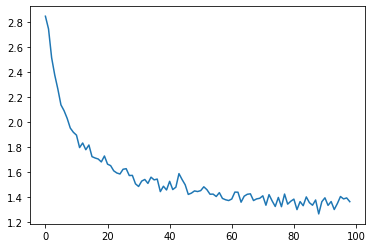

In [19]:
plt.plot(all_loss)

In [20]:
##########################################################################
################## Implementing the RNN pytorch package ##################
##########################################################################

In [58]:
# define pytorch recurrent network
class NameRNN(nn.Module):
    def __init__(self,in_dim,hid_dim,out_dim,n_layer):
        super(NameRNN,self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = n_layer
        
        # define the RNN layers
        self.rnn = nn.RNN(in_dim,hid_dim,n_layer,batch_first=True,nonlinearity='relu')
        
        # fully connected layer
        self.final = nn.Linear(hid_dim,out_dim)
        
        # softmax layer
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self,x):
        
        batch_size = x.size(0)
        
        # initialize the hidden layer for first input
        hidden = self.init_hidden(batch_size)
        
        # passing in the iput and hidden state into model and get output
        out, hidden = self.rnn(x,hidden)
        
        # reshaping the output to fit into fully connected layers
        out = out.contiguous().view(-1,self.hid_dim)
        out = self.final(out)
        out = self.softmax(out)
        return out, hidden
    
    def init_hidden(self,batch_size):
        return torch.zeros(self.layer,batch_size,self.hid_dim)

In [66]:
# RNN Variables
in_hid = n_letters
hid_dim = 30
layer_num = 2
out_dim = n_category

# define the model
rnn_model = NameRNN(in_hid,out_dim,hid_dim,layer_num)

loss_fn = nn.NLLLoss()
learn_rate = 0.01
optimizer = torch.optim.SGD(rnn_model.parameters(),lr=learn_rate)

In [67]:
rnn_model(line_to_tensor('A'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([[-3.2255, -3.3949, -3.3813, -3.3591, -3.4650, -3.6755, -3.1769, -3.2556,
          -3.5007, -3.5710, -3.3515, -3.1142, -3.4969, -3.6678, -3.2503, -3.6037,
          -3.4557, -3.6006, -3.3730, -3.6471, -3.4796, -3.2971, -3.4535, -3.2871,
          -3.4906, -3.5161, -3.5623, -3.0863, -3.2490, -3.4288]],
        grad_fn=<LogSoftmaxBackward>),
 tensor([[[0.0000, 0.2917, 0.2844, 0.0000, 0.0443, 0.0000, 0.0000, 0.0847,
           0.0597, 0.0236, 0.2027, 0.0678, 0.1048, 0.0249, 0.3074, 0.1491,
           0.0000, 0.2665]],
 
         [[0.0000, 0.0105, 0.0000, 0.0400, 0.1196, 0.1964, 0.0000, 0.2134,
           0.1341, 0.0000, 0.0617, 0.3458, 0.0000, 0.0772, 0.1914, 0.1955,
           0.0000, 0.0000]]], grad_fn=<StackBackward>))

In [68]:
def RNN_train(category_tensor, line_tensor):
    optimizer.zero_grad()
    #hidden = rnn_model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn_model(line_tensor[i].view(-1,1,56))
    
    loss = loss_fn(output,category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.data

start = time.time()
current_loss = 0
all_loss = []

for epoch in range(1,n_epochs):
    category, line, category_tensor, line_tensor = random_train_data()
    output,loss = RNN_train(category_tensor,line_tensor)
    current_loss += loss
    
    # print epoch number , name and guess
    if epoch%print_every ==0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess==category else '✗ (%s)' %category 
        print('%d %d%% (%s) %.4f %s / %s %s'%(epoch,epoch/n_epochs*100,time_since(start),loss,line,guess,correct))
        
    # add current loss avg to a list of losses
    if epoch%plot_every ==0:
        all_loss.append(current_loss/plot_every)
        current_loss = 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 11s) 2.7673 Abdurahmanov / Korean ✗ (Russian)
10000 10% (0m 22s) 2.5907 Lambert / Dutch ✗ (French)
15000 15% (0m 34s) 3.1709 Middlesworth / Irish ✗ (Dutch)
20000 20% (0m 46s) 2.5277 Murray / Irish ✗ (Scottish)
25000 25% (0m 59s) 2.6986 Partridge / French ✗ (English)
30000 30% (1m 10s) 2.5936 Elenin / Korean ✗ (Russian)
35000 35% (1m 22s) 2.0922 Bahar / German ✗ (Arabic)
40000 40% (1m 33s) 1.0652 Horiatis / Greek ✓
45000 45% (1m 44s) 4.1156 Kalogeria / Japanese ✗ (Greek)
50000 50% (1m 55s) 2.8638 La / Japanese ✗ (Vietnamese)
55000 55% (2m 5s) 2.4724 Line / French ✗ (English)
60000 60% (2m 16s) 1.6469 Crossland / English ✓
65000 65% (2m 27s) 1.7941 Costa / Japanese ✗ (Portuguese)
70000 70% (2m 38s) 2.8624 Lebeau / Vietnamese ✗ (French)
75000 75% (2m 49s) 3.1794 Naifeh / Vietnamese ✗ (Arabic)
80000 80% (3m 0s) 1.3127 Schroder / German ✓
85000 85% (3m 11s) 3.0445 Robins / Greek ✗ (English)
90000 90% (3m 22s) 1.7852 Raghailligh / Russian ✗ (Irish)
95000 95% (3m 34s) 1.1329 Kloss

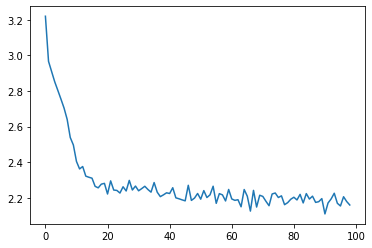

In [70]:
plt.plot(all_loss)

In [71]:
##########################################################################
################## Implementing the LSTM pytorch package ##################
##########################################################################

In [146]:
class LSTM(nn.Module):
    def __init__(self,in_dim,hid_dim,out_dim,num_layer):
        super(LSTM,self).__init__()
        
        self.in_dim, self.hid_dim, self.out_dim, self.layer = in_dim,hid_dim,out_dim,num_layer
        
        # LSTM
        self.lstm = nn.LSTM(in_dim,hid_dim,num_layer,batch_first=True)
        
        # final layer 
        self.final = nn.Linear(hid_dim,out_dim)
        
        # softmax layer
        self.softmax = nn.LogSoftmax()
        
    def forward(self,x):
        
        # initialize the hidden state
        h0 = Variable(torch.zeros(self.layer,x.size(0),self.hid_dim))
        c0 = Variable(torch.zeros(self.layer,x.size(0),self.hid_dim))
        
        # process the output
        output, (hn,cn) = self.lstm(x,(h0,c0))
        
        # reshaping the output to fit into fully connected linear layer
        output = output.contiguous().view(-1,self.hid_dim)
        output = self.final(output)
        output = self.softmax(output)
        return output

In [147]:
# lstm Variables
in_hid = n_letters
hid_dim = 60
layer_num = 1
out_dim = n_category

# define the model
lstm = LSTM(in_hid,hid_dim,out_dim,layer_num)

loss_fn = nn.NLLLoss()
learn_rate = 0.01
optimizer = torch.optim.SGD(lstm.parameters(),lr=learn_rate)

In [148]:
lstm(line_to_tensor('A'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.9623, -3.0415, -2.9963, -2.8254, -2.8879, -2.8997, -2.8010, -2.8192,
         -2.8283, -2.9988, -2.8019, -2.8553, -2.9779, -2.9082, -2.7902, -3.0047,
         -2.7494, -2.9461]], grad_fn=<LogSoftmaxBackward>)

In [149]:
def lstm_train(category_tensor, line_tensor):
    optimizer.zero_grad()
    #hidden = rnn_model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].view(-1,1,56))
    
    loss = loss_fn(output,category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.data

start = time.time()
current_loss = 0
all_loss = []

for epoch in range(1,n_epochs):
    category, line, category_tensor, line_tensor = random_train_data()
    output,loss = lstm_train(category_tensor,line_tensor)
    current_loss += loss
    
    # print epoch number , name and guess
    if epoch%print_every ==0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess==category else '✗ (%s)' %category 
        print('%d %d%% (%s) %.4f %s / %s %s'%(epoch,epoch/n_epochs*100,time_since(start),loss,line,guess,correct))
        
    # add current loss avg to a list of losses
    if epoch%plot_every ==0:
        all_loss.append(current_loss/plot_every)
        current_loss = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 15s) 2.9021 Shirasu / Polish ✗ (Japanese)
10000 10% (0m 31s) 2.7845 Esteves / Greek ✗ (Portuguese)
15000 15% (0m 47s) 1.7400 Sklavenitis / Greek ✓
20000 20% (1m 3s) 0.9923 Stamatas / Greek ✓
25000 25% (1m 19s) 0.8227 Vassilopulos / Greek ✓
30000 30% (1m 35s) 0.9184 Stamatas / Greek ✓
35000 35% (1m 51s) 0.3610 Glazunov / Russian ✓
40000 40% (2m 7s) 0.9604 Papoutsis / Greek ✓
45000 45% (2m 24s) 2.2738 Beatty / Irish ✗ (English)
50000 50% (2m 40s) 1.9665 Mackay / Irish ✗ (Scottish)
55000 55% (2m 56s) 2.0722 Vanwell / Czech ✗ (English)
60000 60% (3m 12s) 2.4579 Hojo / Portuguese ✗ (Japanese)
65000 65% (3m 28s) 2.4923 Exon / Korean ✗ (English)
70000 70% (3m 45s) 1.1565 Yong / Chinese ✓
75000 75% (4m 1s) 0.0470 Hamatov / Russian ✓
80000 80% (4m 17s) 4.0242 Clark / Polish ✗ (Irish)
85000 85% (4m 33s) 1.3130 Fung / Chinese ✓
90000 90% (4m 49s) 1.5025 Fenstermacher / German ✓
95000 95% (5m 5s) 1.7098 Saeki / Italian ✗ (Japanese)


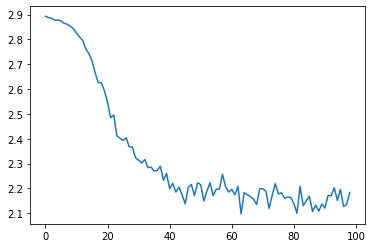

In [150]:
plt.plot(all_loss)

In [122]:
##########################################################################
##################    Evaluate the Predicted Results   ##################
##########################################################################

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


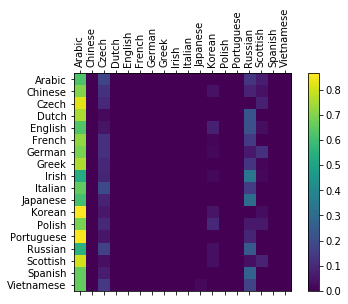

In [138]:
# plot a confusio matrix
confusion = torch.zeros(n_category,n_category)
n_confusion = 1000

# return a output given a name
def evaluate(line_tensor,model):
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor)
    return output

# go through a biunch of examples and record which are correctly guessed

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_train_data()
    output = evaluate(line_tensor,rnn_model)
    guess, guess_i = category_from_output(output)
    category_i = all_category.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_category):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_category,rotation=90)
ax.set_yticklabels(['']+all_category)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


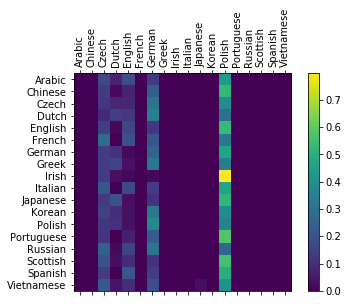

In [151]:
# plot a confusio matrix for LSTM
confusion = torch.zeros(n_category,n_category)
n_confusion = 1000

# return a output given a name
def evaluate(line_tensor,model):
    
    for i in range(line_tensor.size()[0]):
        output = model(line_tensor)
    return output

# go through a biunch of examples and record which are correctly guessed

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_train_data()
    output = evaluate(line_tensor,lstm)
    guess, guess_i = category_from_output(output)
    category_i = all_category.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_category):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_category,rotation=90)
ax.set_yticklabels(['']+all_category)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))